# Image Clustering Analysis
this overall function will do below
1. Data Loading and Cleaning: Load the images, put the url into a variable that i can set later on, resize and normalized
2. Feature Extraction: Convert the cleaned text into numerical features using your proposed method.
3. Optimal Cluster Determination: Use the Elbow Method and Silhouette Score to determine the optimal number of clusters. The optimal number of clusters is determined based on the highest silhouette score.
4. Clustering: Perform clustering using K-Means with the optimal number of clusters.
5. Print Cluster Content: Print the content of each cluster, including the number of members in each cluster.
6. PCA Scatter Plot: Visualize the clusters using a 2D scatter plot with PCA.
7. prepare the output to a list object in python

## Preparing modules

In [1]:
import pandas as pd
import numpy as np
import requests
from collections import defaultdict
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from urllib.parse import urlsplit, urlunsplit
import data_connector

# Step 1: Data Loading and Cleaning
def load_image(url, url_prefix, size=(512, 512)):
    # Remove the filename extension
    parts = list(urlsplit(url))
    path = parts[2]
    path = '/'.join(part.rsplit('.', 1)[0] for part in path.split('/'))
    parts[2] = path
    url = urlunsplit(parts)

    # Add the URL prefix
    full_url = url_prefix + url
    print(full_url)

    response = requests.get(full_url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(size)
    img = np.array(img)
    if img.shape[2] == 4:
        img = img[:, :, :3]  # Remove alpha channel if present
    img = img / 255.0  # Normalize
    return img

# Step 2: Feature Extraction
def extract_features(img):
    h, w, c = img.shape
    return img.reshape(1, h * w * c)

# Main function to execute the steps
def main(df, url_column, url_prefix):
    all_features = []
    for url in df[url_column]:
        img = load_image(url, url_prefix)
        features = extract_features(img)
        all_features.append(features)
    all_features = np.vstack(all_features)

    # Determine optimal clusters
    optimal_clusters, inertia, silhouette_scores = determine_optimal_clusters(all_features)
    if optimal_clusters is None:
        print("Could not determine optimal clusters due to insufficient unique labels.")
        return []
    
    cluster_labels, kmeans = perform_clustering(all_features, optimal_clusters)
    print_cluster_content(cluster_labels)
    pca_result = visualize_clusters(all_features, cluster_labels)
    output = prepare_output(cluster_labels, pca_result, all_features)
    outputlist = prepare_output_final(output)
    
    # Calculate average distance from centroid for each cluster
    average_distances = average_distance_from_centroid(outputlist)
    score = normalize_distances(average_distances)

    # output_final = prepare_output_final(output,score)

    return output, optimal_clusters, inertia, silhouette_scores, outputlist, score

# Step 3: Optimal Cluster Determination
def determine_optimal_clusters(features):
    inertia = []
    silhouette_scores = []
    range_n_clusters = list(range(2, min(10, len(features))))
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(features)
        inertia.append(kmeans.inertia_)
        if len(np.unique(cluster_labels)) > 1:
            silhouette_scores.append(silhouette_score(features, cluster_labels))
        else:
            silhouette_scores.append(-1)
    
    if all(score == -1 for score in silhouette_scores):
        return None, inertia, silhouette_scores
    
    optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
    return optimal_clusters, inertia, silhouette_scores

# Step 4: Clustering
def perform_clustering(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(features)
    return cluster_labels, kmeans

# Step 5: Print Cluster Content
def print_cluster_content(cluster_labels):
    unique_labels = np.unique(cluster_labels)
    for label in unique_labels:
        print(f"Cluster {label}: {np.sum(cluster_labels == label)} members")

# Step 6: PCA Scatter Plot
def visualize_clusters(features, cluster_labels):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Clusters Visualization with PCA')
    # plt.show()
    return pca_result

# Step 7: Prepare Output
def prepare_output(cluster_labels, pca_result, features):
    output = []
    unique_labels = np.unique(cluster_labels)
    for label in unique_labels:
        members = np.where(cluster_labels == label)[0].tolist()
        cluster_pca1 = pca_result[cluster_labels == label, 0].tolist()
        cluster_pca2 = pca_result[cluster_labels == label, 1].tolist()
        cluster_features = features[cluster_labels == label]
        # if len(np.unique(cluster_labels)) > 1:
        #     similarity_score = silhouette_score(cluster_features, [label] * len(cluster_features))
        # else:
        #     similarity_score = -1
        similarity_score = 0
        output.append({
            'cluster': label,
            'members': members,
            'pca1': cluster_pca1,
            'pca2': cluster_pca2,
            'similarity_score': similarity_score
        })
    
    # Convert to DataFrame
    df_output = pd.DataFrame(output)
    
    # Convert DataFrame to list
    list_output = df_output.to_numpy().tolist()
    
    return list_output

# Function to compute the centroid of a cluster
def compute_centroid(points):
    points = np.array(points)
    return np.mean(points, axis=0)

# Function to calculate the Euclidean distance
def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

# Function to compute the average distance from the centroid for each cluster
def average_distance_from_centroid(data):
    clusters = defaultdict(list)
    
    # Grouping points by cluster number
    for entry in data:
        _, _, cluster_number, PCA1, PCA2 = entry
        clusters[cluster_number].append((PCA1, PCA2))
    
    average_distances = {}
    
    for cluster_number, points in clusters.items():
        centroid = compute_centroid(points)
        total_distance = sum(euclidean_distance(point, centroid) for point in points)
        average_distance = total_distance / len(points)
        average_distances[cluster_number] = average_distance
    
    return average_distances

# Function to normalize the distances to a score between 0 and 1
def normalize_distances(average_distances):
    min_distance = min(average_distances.values())
    max_distance = max(average_distances.values())
    
    normalized_scores = {}
    for cluster_number, avg_distance in average_distances.items():
        if max_distance == min_distance:  # Avoid division by zero
            normalized_scores[cluster_number] = 0.0
            normalized_scores[cluster_number] = 1 - normalized_scores[cluster_number]
        else:
            normalized_scores[cluster_number] = (avg_distance - min_distance) / (max_distance - min_distance)
            normalized_scores[cluster_number] = 1 - normalized_scores[cluster_number]
    
    return normalized_scores

def prepare_output_final(output):
    # create list of:
    memberIdx = 0
    outputlist = []
    
    for i in range(len(output)):
        # 0: cluster number
        # 1: member
        # 2: PCA1
        # 3: PCA2
        # 4: Sim Score ->> from score list
        
        # iterate thru member
        for j in range(len(output[i][1])):
            memberIndex = output[i][1][j]
            PCA1 = output[i][2][j]
            PCA2 = output[i][3][j]
            clusterId = output[i][0]
            key_id = result_df['key_id'][memberIndex]
            
            # print(key_id, memberIndex, clusterId, PCA1, PCA2)
            outputlist.append([key_id, memberIndex, clusterId, PCA1, PCA2])
    
    return outputlist

## Main function to execute the steps

## 1. Query Jobs data from server and mark the jobs

In [2]:
strSQL = """
select 	a.id as jobsid,
        a.*,
		c.id as key_monitoring_media_social, 
		d.id as key_monitoring_media_online,
		c.*
from 	screen_analisis_ai a 
		inner join monitoring_search b
			on cast(a.monitoring_id as varchar) = cast(b.id as varchar)
		inner join monitoring_media_social c
			on b.id = c.monitoring_search_id 
		left outer join  monitoring_media_online d
			on d.monitoring_search_id = c.monitoring_search_id 
where a.jenis_analisa = '20'
and a.status = 1
order by a.created desc 
limit 1
"""


df_job = data_connector.execute_query_psql(strSQL)
if len(df_job) == 0:
    # get out, nothing to do
    print('Zero jobs, quitting now')
    quit()
    
similarity_treshold = 0.9
i_process_id = df_job['jobsid'][0]
screen_name = ''
database_keyword_id = df_job['key_monitoring_media_social'][0]
social_media_monitoring_id = df_job['key_monitoring_media_social'][0]
media_online_monitoring_id = df_job['key_monitoring_media_online'][0]

# print(database_keyword_id)
print(similarity_treshold)
print(i_process_id)
print(social_media_monitoring_id)
print(media_online_monitoring_id)


# Prepare SQL Statement
print(i_process_id)
sql = "update screen_analisis_ai set status = 2, last_status_update = now(), start_process = now() where id = %s"
sql = sql.replace('%s', str(i_process_id))

print(sql)
row_count = data_connector.execute_query_psql(sql)
print('update ' + str(row_count) + ' rows')

# Create Header Record
sql = "insert into ret_analysis_header (job_id, datetime_start, user_id) values (%s, now(), %s)" % (i_process_id,"1")
# Execute the query
data_connector.execute_query_psql(sql)



0.9
5073
f55df6f6-d65b-4847-8b62-35d14d2713fc
None
5073
update screen_analisis_ai set status = 2, last_status_update = now(), start_process = now() where id = 5073
update 1 rows


1

## 2. Iterate through the result

In [3]:
def recording_output(output_final, score, platform_id):
# id, ref_id, cluster_no, platform_id, job_id
    query_sql = """
    insert into ret_cluster_image_result_monitor 
    (ref_id, cluster_no, platform_id, job_id, pca1, pca2, score)
    """

    for i in range(len(output_final)):
        sim_score = score[output_final[i][2]]
        valuesql = "values ( '" + str(output_final[i][0]) + "','" + str(output_final[i][2])  + "','" + str(platform_id) + "','" + str(i_process_id) + "','"+ str(output_final[i][3]) +"','" + str(output_final[i][4]) + "','" + str(sim_score) + "' )"
        ssql = query_sql + valuesql
        print(ssql)
        data_connector.execute_query_psql(ssql)
        


https://disestages.com/api/media/photo/download/tiktok/7111572596176506139
https://disestages.com/api/media/photo/download/tiktok/7260195496013155589
https://disestages.com/api/media/photo/download/tiktok/7376989341832318226
https://disestages.com/api/media/photo/download/tiktok/7372252642497662213
https://disestages.com/api/media/photo/download/tiktok/7376954285956861202
https://disestages.com/api/media/photo/download/tiktok/7280875944003308805
https://disestages.com/api/media/photo/download/tiktok/7376064355890253074
https://disestages.com/api/media/photo/download/tiktok/7175116397335399706
https://disestages.com/api/media/photo/download/tiktok/7377019847978323207
https://disestages.com/api/media/photo/download/tiktok/7113050391754837275
https://disestages.com/api/media/photo/download/tiktok/7373666536860536069
https://disestages.com/api/media/photo/download/tiktok/7111600434757782811
https://disestages.com/api/media/photo/download/tiktok/7362020027949649157
https://disestages.com/ap

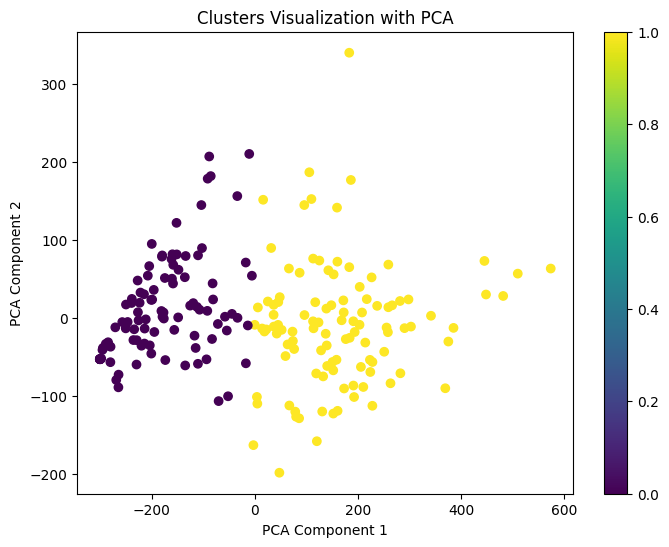

In [4]:
img_prefix_http = "https://disestages.com/api/media/photo/download/%s/"

# Processing jobs for each platform
# 10 = tiktok
# 20 = youtube
# 30 = instagram_post
# 40 = facebook_post
# 50 = google_result
# 60 = twitter_tweets

iRowCount = 0

if (df_job['is_twitter'][0]):
    ssql = """
    select 	a.id as key_id,
            b.filename as filename
    from 	twitter_tweets a inner join media_files b 
            on a.id = b.id 
    where a.monitoring_id = '%s'
    """
    ssql = ssql % (social_media_monitoring_id)
    # print(ssql)
    img_prefix_http = "https://disestages.com/api/media/photo/download/%s/"
    img_prefix_http = img_prefix_http % "twitter"
    # print(img_prefix_http)
    
    result_df = data_connector.execute_query_psql(ssql)
    if (len(result_df)) > 0:
        # processing
        output, optimal_clusters, inertia, silhouette_scores, output_final, score = main(result_df, 'filename', img_prefix_http)
        # Recording Result
        recording_output(output_final, score, 60)
        iRowCount = iRowCount + len(output_final)

if (df_job['is_tiktok'][0]):
    ssql = """
    select 	a.id as key_id,
            b.filename as filename
    from 	tiktok a inner join media_files_tiktok b 
            on a.id = b.tiktok_id 
    where a.monitoring_id = '%s'
    """
    ssql = ssql % (social_media_monitoring_id)
    # print(ssql)
    img_prefix_http = "https://disestages.com/api/media/photo/download/%s/"
    img_prefix_http = img_prefix_http % "tiktok"
    # print(img_prefix_http)
    
    result_df = data_connector.execute_query_psql(ssql)
    if (len(result_df)) > 0:
        # processing
        output, optimal_clusters, inertia, silhouette_scores, output_final, score = main(result_df, 'filename', img_prefix_http)
    
        # Recording Result
        recording_output(output_final, score, 10)
        iRowCount = iRowCount + len(output_final)
    
elif (df_job['is_facebook'][0]):
    ssql = """
    select 	a.id as key_id,
            b.filename as filename
    from 	facebook_post a inner join media_files_facebook b
    		on a.id = b.facebook_id 
    where a.monitoring_id = '%s'
    """
    ssql = ssql % (social_media_monitoring_id)
    # print(ssql)

    img_prefix_http = "https://disestages.com/api/media/photo/download/%s/"
    img_prefix_http = img_prefix_http % "facebook"
    # print(img_prefix_http)
    
    result_df = data_connector.execute_query_psql(ssql)
    
    if (len(result_df)) > 0:
        # processing
        output, optimal_clusters, inertia, silhouette_scores, output_final, score = main(result_df, 'filename', img_prefix_http)
    
        # Recording Result
        recording_output(output_final, score, 40)
        iRowCount = iRowCount + len(output_final)

    

In [5]:
# Finishing Jobs
# Create Parameter Record
sql = "insert into ret_analysis_parameter (job_id, param_id, param_name, param_value) values (%s, %s, %s, %s)"
# Execute the query
data_connector.execute_query_psql(sql % (i_process_id, 1, "'#Content Processed'",iRowCount))

# Create Tweet Cluster Record
sql = "update ret_analysis_header set datetime_finish = NOW() where job_id = %s"
# Executing query
data_connector.execute_query_psql(sql % (i_process_id) )

sql = "update screen_analisis_ai set status = 3, duration = EXTRACT(EPOCH FROM (now() - start_process)), end_process = NOW() where id = %s"
data_connector.execute_query_psql(sql % (i_process_id))

print('inserting result finished')



inserting result finished


In [6]:
# wait 10 seconds before finished
import time
time.sleep(10)